In [1]:
from monai.utils import set_determinism
import os, glob, torch, SimpleITK as sitk
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from random import seed, sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from monai.networks.nets import AttentionUnet
from monai.losses import DiceFocalLoss
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    ResizeWithPadOrCropd, ToTensord, RandAffined, RandGaussianNoised,
    Rand3DElasticd, RandRotated, RandFlipd, RandShiftIntensityd
)
from monai.metrics import DiceMetric
import scipy.ndimage
import seaborn as sns
from monai.losses import DiceCELoss

In [2]:
# === SETUP ===
set_determinism(seed=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === PATHS ===
KTRANS_DIR = r"C:\Users\anude\Downloads\ProstateXKtrains-train-fixed"
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
IMAGES_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Images-Train100.csv"

# === LOAD METADATA ===
findings_df = pd.read_csv(FINDINGS_CSV)
images_df = pd.read_csv(IMAGES_CSV)
meta_df = pd.merge(images_df, findings_df, on=["ProxID", "fid"])

In [3]:

# === UTILS ===
def load_dicom_volume(proxid, series_description):
    """
    Loads a full DICOM volume for a patient using the series description or fallback keywords. 
    Searches recursively in the patient's folder and returns a SimpleITK.Image.
    """
    patient_dir = os.path.join(DICOM_ROOT, proxid)
    fallback_keywords = {
        "ADC": ["adc"],
        "T2": ["t2", "t2w"],
        "DWI": ["dwi", "diffusion", "ep2d_diff", "ep2d"]
    }
    keywords = fallback_keywords.get(series_description.upper(), [series_description.lower()])
    for root, _, _ in os.walk(patient_dir):
        for keyword in keywords:
            if keyword in root.lower():
                dicoms = sorted(glob.glob(os.path.join(root, "*.dcm")))
                if dicoms:
                    reader = sitk.ImageSeriesReader()
                    reader.SetFileNames(dicoms)
                    return reader.Execute()
    raise FileNotFoundError(f"{proxid}: {series_description} not found.")

def load_ktrans(proxid):
    """
    Loads the Ktrans .mhd image for a patient if it exists. Returns a SimpleITK.Image or None if not found.
    """
    path = os.path.join(KTRANS_DIR, proxid, f"{proxid}-Ktrans.mhd")
    return sitk.ReadImage(path) if os.path.exists(path) else None

def parse_ijk(ijk_str):
    """
    Parses a string-formatted IJK coordinate (e.g. "34 52 21") into a tuple of integers. Returns None on failure.
    """
    try: return tuple(map(int, ijk_str.strip().replace(",", " ").split()))
    except: return None

def generate_label_mask(image, ijk_list):
    """
    Creates a binary mask from a list of (i, j, k) lesion coordinates. The mask matches the dimensions of the reference image.
    """
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        try: label[int(k), int(j), int(i)] = 1
        except: continue
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result

def keep_largest_component(pred_mask):
    """
    For each prediction mask in a batch, keeps only the largest connected component to reduce noise and false positives.
    Returns cleaned binary masks as a NumPy array.
    """
    cleaned = []
    for m in pred_mask:
        labeled_array, num_features = scipy.ndimage.label(m)
        if num_features == 0:
            cleaned.append(m)
            continue
        sizes = scipy.ndimage.sum(m, labeled_array, range(num_features + 1))
        largest = (labeled_array == np.argmax(sizes)).astype(np.uint8)
        cleaned.append(largest)
    return np.array(cleaned)

<H1> Data Preprocessing

In [5]:
# === DATASET BUILD ===
os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)
data, labels = [], []

print(" Building dataset...")
for proxid in tqdm(meta_df["ProxID"].unique()):
    try:
        adc = load_dicom_volume(proxid, "ADC")
        ktrans = load_ktrans(proxid)
        t2 = load_dicom_volume(proxid, "T2")
        dwi = load_dicom_volume(proxid, "DWI")

        ktrans = sitk.Resample(ktrans, adc)
        t2 = sitk.Resample(t2, adc)
        dwi = sitk.Resample(dwi, adc)

        pos_findings = meta_df[(meta_df["ProxID"] == proxid) & (meta_df["ClinSig"] == 1)]
        ijk_coords = [parse_ijk(i) for i in pos_findings["ijk"].dropna()]
        ijk_coords = [c for c in ijk_coords if c is not None]
        mask = generate_label_mask(adc, ijk_coords) if ijk_coords else sitk.Image(adc.GetSize(), sitk.sitkUInt8)
        mask.CopyInformation(adc)

        paths = {
            "adc": f"images/{proxid}_adc.nii.gz",
            "ktrans": f"images/{proxid}_ktrans.nii.gz",
            "t2": f"images/{proxid}_t2.nii.gz",
            "dwi": f"images/{proxid}_dwi.nii.gz",
            "label": f"labels/{proxid}_label.nii.gz"
        }
        sitk.WriteImage(adc, paths["adc"])
        sitk.WriteImage(ktrans, paths["ktrans"])
        sitk.WriteImage(t2, paths["t2"])
        sitk.WriteImage(dwi, paths["dwi"])
        sitk.WriteImage(mask, paths["label"])

        data.append({"image": [paths["adc"], paths["ktrans"], paths["t2"], paths["dwi"]], "label": paths["label"]})
        labels.append(1 if ijk_coords else 0)
    except Exception as e:
        print(f"{proxid}: {e}")

print(f" Total usable samples: {len(data)}")

 Building dataset...


100%|██████████| 101/101 [01:08<00:00,  1.47it/s]

 Total usable samples: 101


Dataset is balanced by undersampling non-lesion cases and splitting off a stratified test set. MONAI transforms are applied for augmentation during training and standardized preprocessing during testing.

In [7]:
# === BALANCE ===
has_lesion = [d for d, l in zip(data, labels) if l == 1]
no_lesion = [d for d, l in zip(data, labels) if l == 0]
no_lesion_sampled = sample(no_lesion, len(has_lesion))
train_data = has_lesion + no_lesion_sampled
train_labels = [1]*len(has_lesion) + [0]*len(no_lesion_sampled)
_, test_data, _, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# === TRANSFORMS ===
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    RandAffined(keys=["image", "label"], prob=0.3, translate_range=5),
    Rand3DElasticd(keys=["image", "label"], sigma_range=(1,2), magnitude_range=(1,2), prob=0.2),
    RandRotated(keys=["image", "label"], range_x=np.pi/12, prob=0.3),
    RandGaussianNoised(keys="image", prob=0.2),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

train_loader = DataLoader(Dataset(train_data, transform=train_transforms), batch_size=1, shuffle=True)
test_loader = DataLoader(Dataset(test_data, transform=test_transforms), batch_size=1)

A 3D Attention UNet for multi-channel lesion segmentation with class-weighted Dice-Focal loss and trains it over 30 epochs. It uses MONAI's DiceMetric for evaluation and optimizes with Adam.

In [9]:


# === MODEL ===
model = AttentionUnet(
    spatial_dims=3,
    in_channels=4,
    out_channels=2,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2)
).to(device)

loss_fn = DiceFocalLoss(to_onehot_y=True, softmax=True, weight=torch.tensor([0.2, 0.8]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# === TRAIN ===
print(" Training...")
best_f1 = 0
for epoch in range(30):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

    # Eval on test for best model
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            true_mask = batch["label"].cpu().numpy()
            pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
            pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
            pred_mask = keep_largest_component(pred_mask)

            lesion_detected = int(np.any(pred_mask) and pred_mask.sum() > 500)
            y_pred.append(lesion_detected)
            y_true.append(int(np.any(true_mask)))

    f1 = f1_score(y_true, y_pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model.pth")
        print(f" New best model saved with F1: {f1:.4f}")

print(" Training complete")

 Training...
[Epoch 1] Loss: 25.5647
 New best model saved with F1: 0.4444
[Epoch 2] Loss: 24.3575
 New best model saved with F1: 0.4800
[Epoch 3] Loss: 24.0314
[Epoch 4] Loss: 23.7820
[Epoch 5] Loss: 23.5890
[Epoch 6] Loss: 23.4394
[Epoch 7] Loss: 23.2397
[Epoch 8] Loss: 23.0901
[Epoch 9] Loss: 22.9573
[Epoch 10] Loss: 22.8483
[Epoch 11] Loss: 22.7403
[Epoch 12] Loss: 22.6460
[Epoch 13] Loss: 22.5619
[Epoch 14] Loss: 22.4872
[Epoch 15] Loss: 22.4192
[Epoch 16] Loss: 22.3580
[Epoch 17] Loss: 22.3026
[Epoch 18] Loss: 22.2523
[Epoch 19] Loss: 22.2060
[Epoch 20] Loss: 22.1641
[Epoch 21] Loss: 22.1251
[Epoch 22] Loss: 22.0893
[Epoch 23] Loss: 22.0711
[Epoch 24] Loss: 22.0294
[Epoch 25] Loss: 21.9978
[Epoch 26] Loss: 21.9691
[Epoch 27] Loss: 21.9438
[Epoch 28] Loss: 21.9214
[Epoch 29] Loss: 21.9010
[Epoch 30] Loss: 21.8822
 Training complete


Attention UNet model is evaluated on the test set using sliding window inference

 Evaluating best model...

 Test Set Detection-Level Metrics:
 Accuracy:  0.3810
 Precision: 0.3158
 Recall:    1.0000
 F1 Score:  0.4800


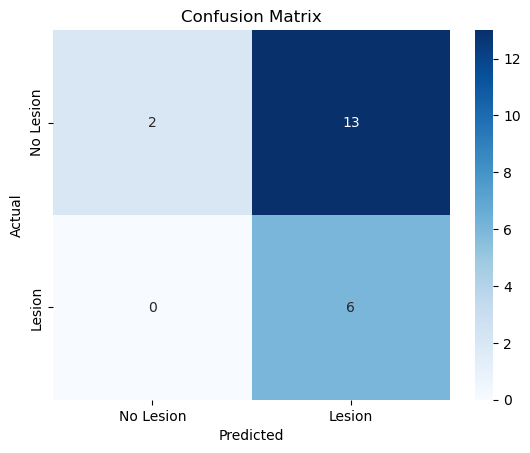

In [17]:

# === EVALUATE ===
print(" Evaluating best model...")
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
        pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
        pred_mask = keep_largest_component(pred_mask)

        lesion_detected = int(np.any(pred_mask) and pred_mask.sum() > 500)
        y_pred.append(lesion_detected)
        y_true.append(int(np.any(true_mask)))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print("\n Test Set Detection-Level Metrics:")
print(f" Accuracy:  {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall:    {rec:.4f}")
print(f" F1 Score:  {f1:.4f}")

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lesion", "Lesion"], yticklabels=["No Lesion", "Lesion"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Evaluates the trained Attention UNet using Dice score and detection accuracy, applying morphological cleaning and overlay visualisation.

 Evaluating the model


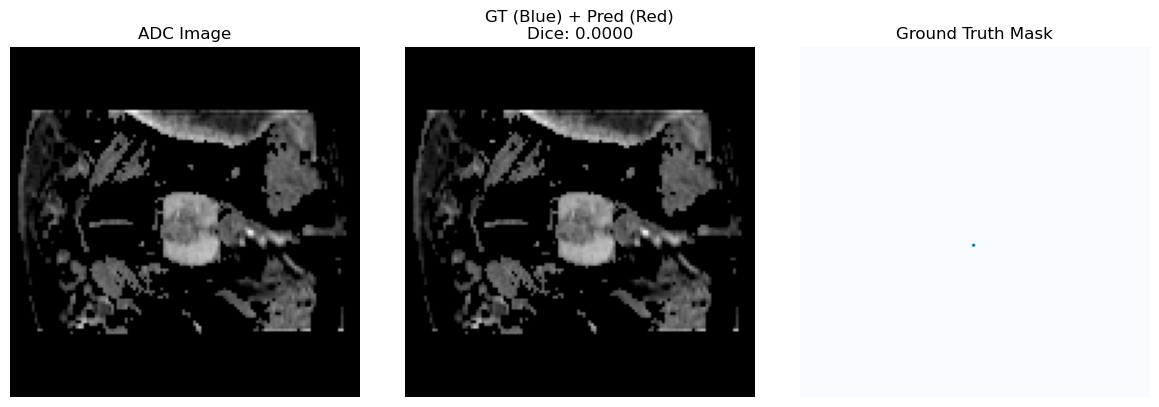

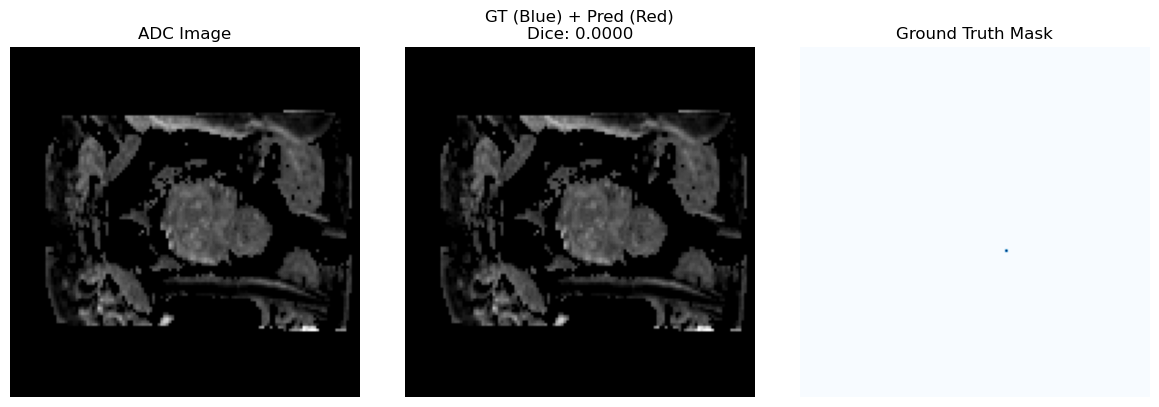

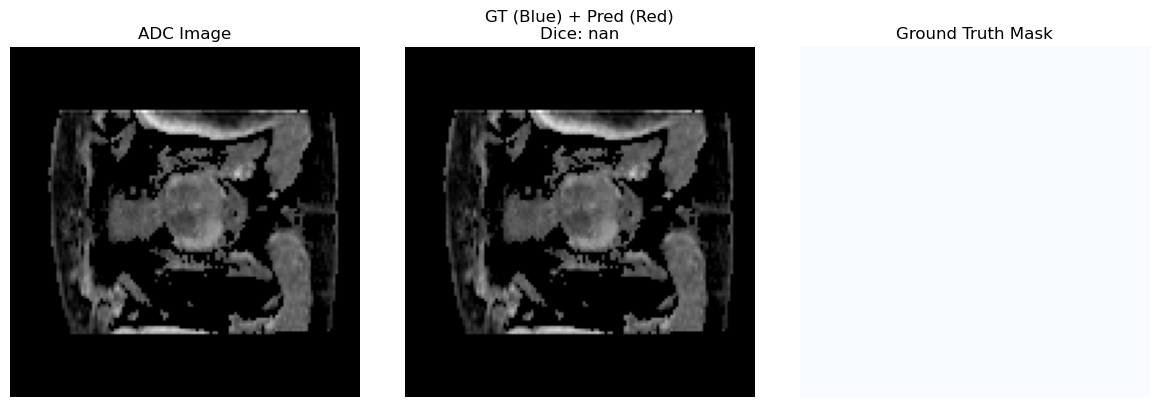

In [19]:
from scipy.ndimage import binary_closing

def generate_label_mask(image, ijk_list, radius=2):
    """
    Creates a binary 3D mask around lesion coordinates (ijk_list) by marking a small cubic region (radius-controlled) around each point.
    """
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                for dz in range(-radius, radius + 1):
                    xi, yj, zk = i + dx, j + dy, k + dz
                    if 0 <= zk < label.shape[0] and 0 <= yj < label.shape[1] and 0 <= xi < label.shape[2]:
                        label[zk, yj, xi] = 1
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result


def clean_prediction(pred_mask, structure_size=3):
    """
    Applies 3D morphological closing to each predicted mask to fill small holes and smooth boundaries. This helps reduce noise and improve segmentation coherence.
    """
    cleaned = []
    for m in pred_mask:
        m = binary_closing(m, structure=np.ones((structure_size, structure_size, structure_size)))
        cleaned.append(m.astype(np.uint8))
    return np.array(cleaned)


# === Evaluation with Dice Score + Visualisation ===
dice_metric = DiceMetric(include_background=False, reduction="mean")

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []
dice_scores = []

print(" Evaluating the model")
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
        pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
        pred_mask = keep_largest_component(pred_mask)
        pred_mask = clean_prediction(pred_mask, structure_size=3)

        lesion_detected = int(np.any(pred_mask) and pred_mask.sum() > 500)
        y_pred.append(lesion_detected)
        y_true.append(int(np.any(true_mask)))

        # === Dice calculation (if lesion present in GT or prediction) ===
        if np.any(pred_mask) or np.any(true_mask):
            pred_tensor = torch.tensor(pred_mask).unsqueeze(1)
            true_tensor = torch.tensor(true_mask, dtype=torch.uint8).unsqueeze(1)
            dice = dice_metric(pred_tensor, true_tensor).item()
            dice_scores.append(dice)

        # === Visualise first 3 patients only ===
        if idx < 3:
            # Use ADC instead of T2 for overlay
            img = images[0][0].cpu().numpy()  # ADC image (resample reference)
            slice_idx = img.shape[2] // 2
        
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        
            # T2 image (unchanged)
            axs[0].imshow(img[:, :, slice_idx], cmap="gray")
            axs[0].set_title("ADC Image")
            axs[0].axis("off")
        
            # Overlay both prediction and ground truth
            pred_overlay = np.ma.masked_where(pred_mask[0][:, :, slice_idx] == 0, pred_mask[0][:, :, slice_idx])
            gt_overlay = np.ma.masked_where(true_mask[0].squeeze()[:, :, slice_idx] == 0, true_mask[0].squeeze()[:, :, slice_idx])
        
            axs[1].imshow(img[:, :, slice_idx], cmap="gray")
            axs[1].imshow(gt_overlay, cmap="Blues", alpha=0.5)
            axs[1].imshow(pred_overlay, cmap="Reds", alpha=0.5)
            axs[1].set_title(f"GT (Blue) + Pred (Red)\nDice: {dice:.4f}")
            axs[1].axis("off")
        
            # Ground Truth only for reference
            axs[2].imshow(true_mask[0].squeeze()[:, :, slice_idx], cmap="Blues")
            axs[2].set_title("Ground Truth Mask")
            axs[2].axis("off")
        
            plt.tight_layout()
            plt.show()





<h1> Improving the model performance</h1>
We will use Dice + Cross Entropy Loss instead of DiceFocalLoss and introduce Test-Time Augmentation (TTA) for more robust inference.
Applies more diverse augmentations for better generalisation.

In [21]:
# === SETUP ===
set_determinism(seed=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === PATHS ===
KTRANS_DIR = r"C:\Users\anude\Downloads\ProstateXKtrains-train-fixed"
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
IMAGES_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Images-Train100.csv"

# === LOAD METADATA ===
findings_df = pd.read_csv(FINDINGS_CSV)
images_df = pd.read_csv(IMAGES_CSV)
meta_df = pd.merge(images_df, findings_df, on=["ProxID", "fid"])

In [22]:


# === UTILS ===
def load_dicom_volume(proxid, series_description):
    """
    Loads a DICOM volume for a given patient and modality using series description keywords. 
    Uses fallback keyword matching to locate the correct series within nested folders.
    """
    patient_dir = os.path.join(DICOM_ROOT, proxid)
    fallback_keywords = {
        "ADC": ["adc"],
        "T2": ["t2", "t2w"],
        "DWI": ["dwi", "diffusion", "ep2d_diff", "ep2d"]
    }
    keywords = fallback_keywords.get(series_description.upper(), [series_description.lower()])
    for root, _, _ in os.walk(patient_dir):
        for keyword in keywords:
            if keyword in root.lower():
                dicoms = sorted(glob.glob(os.path.join(root, "*.dcm")))
                if dicoms:
                    reader = sitk.ImageSeriesReader()
                    reader.SetFileNames(dicoms)
                    return reader.Execute()
    raise FileNotFoundError(f"{proxid}: {series_description} not found.")

def load_ktrans(proxid):
    """
    Loads the .mhd Ktrans image for the specified patient if it exists. Returns a SimpleITK.Image or None.
    """
    path = os.path.join(KTRANS_DIR, proxid, f"{proxid}-Ktrans.mhd")
    return sitk.ReadImage(path) if os.path.exists(path) else None

def parse_ijk(ijk_str):
    """
    Parses a string of IJK coordinates into a tuple of integers. Returns None if parsing fails.
    """
    try: return tuple(map(int, ijk_str.strip().replace(",", " ").split()))
    except: return None

def generate_label_mask(image, ijk_list):
    """
    Generates a binary label mask from a list of IJK lesion coordinates aligned with the reference image. Sets voxels at lesion locations to 1.
    """
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        try: label[int(k), int(j), int(i)] = 1
        except: continue
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result

def keep_largest_component(pred_mask):
    """
    Removes small connected components from predicted masks, retaining only the largest structure in each prediction.
    Helps reduce noise and false positives.
    """
    cleaned = []
    for m in pred_mask:
        labeled_array, num_features = scipy.ndimage.label(m)
        if num_features == 0:
            cleaned.append(m)
            continue
        sizes = scipy.ndimage.sum(m, labeled_array, range(num_features + 1))
        largest = (labeled_array == np.argmax(sizes)).astype(np.uint8)
        cleaned.append(largest)
    return np.array(cleaned)
    
def tta_sliding_window(model, images):
    """
    Performs Test-Time Augmentation (TTA) by averaging predictions from original and flipped inputs 
    using sliding window inference. This enhances robustness to spatial variations during evaluation.
    """
    flips = [lambda x: x, lambda x: torch.flip(x, dims=[2])]
    preds = []
    for flip in flips:
        flipped = flip(images)
        pred = sliding_window_inference(flipped, (128, 128, 64), 1, model)
        pred = flip(pred)
        preds.append(pred)
    return torch.mean(torch.stack(preds), dim=0)

def lesion_present(pred_mask, threshold=0.5, min_voxels=300):
    """
    Determines if a lesion is present by thresholding the predicted probability map and
    keeping only the largest component. Returns 1 if the lesion exists and exceeds the voxel count threshold.
    """
    probs = torch.softmax(pred_mask, dim=1)[:, 1].cpu().numpy()
    binary = (probs > threshold).astype(np.uint8)
    binary = keep_largest_component(binary)
    return int(np.any(binary) and binary.sum() > min_voxels)

<h1> Data Preprocessing

In [30]:

# === DATASET BUILD ===
os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)
data, labels = [], []

print(" Building dataset...")
for proxid in tqdm(meta_df["ProxID"].unique()):
    try:
        adc = load_dicom_volume(proxid, "ADC")
        ktrans = load_ktrans(proxid)
        t2 = load_dicom_volume(proxid, "T2")
        dwi = load_dicom_volume(proxid, "DWI")

        ktrans = sitk.Resample(ktrans, adc)
        t2 = sitk.Resample(t2, adc)
        dwi = sitk.Resample(dwi, adc)

        pos_findings = meta_df[(meta_df["ProxID"] == proxid) & (meta_df["ClinSig"] == 1)]
        ijk_coords = [parse_ijk(i) for i in pos_findings["ijk"].dropna()]
        ijk_coords = [c for c in ijk_coords if c is not None]
        mask = generate_label_mask(adc, ijk_coords) if ijk_coords else sitk.Image(adc.GetSize(), sitk.sitkUInt8)
        mask.CopyInformation(adc)

        paths = {
            "adc": f"images/{proxid}_adc.nii.gz",
            "ktrans": f"images/{proxid}_ktrans.nii.gz",
            "t2": f"images/{proxid}_t2.nii.gz",
            "dwi": f"images/{proxid}_dwi.nii.gz",
            "label": f"labels/{proxid}_label.nii.gz"
        }
        sitk.WriteImage(adc, paths["adc"])
        sitk.WriteImage(ktrans, paths["ktrans"])
        sitk.WriteImage(t2, paths["t2"])
        sitk.WriteImage(dwi, paths["dwi"])
        sitk.WriteImage(mask, paths["label"])

        data.append({"image": [paths["adc"], paths["ktrans"], paths["t2"], paths["dwi"]], "label": paths["label"]})
        labels.append(1 if ijk_coords else 0)
    except Exception as e:
        print(f" {proxid}: {e}")

print(f" Total usable samples: {len(data)}")

 Building dataset...


100%|██████████| 101/101 [01:22<00:00,  1.23it/s]

 Total usable samples: 101


The dataset is balanced using a 3:1 negative-to-positive sample ratio to address class imbalance. MONAI transforms apply advanced 3D augmentations like flipping, intensity shift, affine, and elastic distortions for robust training, while test transforms standardise input size and format.

In [32]:


# === BALANCE ===
has_lesion = [d for d, l in zip(data, labels) if l == 1]
no_lesion = [d for d, l in zip(data, labels) if l == 0]
neg_to_pos_ratio = 3
no_lesion_sampled = sample(no_lesion, min(len(no_lesion), len(has_lesion) * neg_to_pos_ratio))
train_data = has_lesion + no_lesion_sampled
train_labels = [1]*len(has_lesion) + [0]*len(no_lesion_sampled)
_, test_data, _, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)


# === TRANSFORMS ===

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.3),
    RandShiftIntensityd(keys="image", offsets=0.1, prob=0.3),
    RandGaussianNoised(keys="image", prob=0.2),
    RandAffined(keys=["image", "label"], prob=0.3, translate_range=5),
    RandRotated(keys=["image", "label"], range_x=np.pi/12, prob=0.3),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])


test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

train_loader = DataLoader(Dataset(train_data, transform=train_transforms), batch_size=1, shuffle=True)
test_loader = DataLoader(Dataset(test_data, transform=test_transforms), batch_size=1)


A 3D Attention UNet with 4 input channels and is optimised using Dice + Cross Entropy Loss. Training includes early stopping with learning rate scheduling and evaluates F1 score on the test set each epoch, saving the best-performing model.

In [34]:

# === MODEL ===
model = AttentionUnet(
    spatial_dims=3,
    in_channels=4,
    out_channels=2,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2)
).to(device)

loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# === TRAIN ===
print(" Training...")
best_f1 = 0
for epoch in range(30):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

    # Eval on test for best model
    model.eval()
    y_true, y_pred = [], []
    # Evaluation (same for final eval too)
    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            true_mask = batch["label"].cpu().numpy()
            pred_mask = tta_sliding_window(model, images)
            detected = lesion_present(pred_mask)
            y_pred.append(detected)
            y_true.append(int(np.any(true_mask)))


    f1 = f1_score(y_true, y_pred, zero_division=0)
    scheduler.step(f1)
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model.pth")
        print(f" New best model saved with F1: {f1:.4f}")

print(" Training complete")


 Training...
[Epoch 1] Loss: 99.0623
 New best model saved with F1: 0.4167
[Epoch 2] Loss: 86.6270
 New best model saved with F1: 0.4545
[Epoch 3] Loss: 80.5914
[Epoch 4] Loss: 75.8768
[Epoch 5] Loss: 72.1637
[Epoch 6] Loss: 69.0173
[Epoch 7] Loss: 67.0272
[Epoch 8] Loss: 65.8455
[Epoch 9] Loss: 64.7742
[Epoch 10] Loss: 63.7322
 New best model saved with F1: 0.5000
[Epoch 11] Loss: 62.7860
[Epoch 12] Loss: 61.9215
[Epoch 13] Loss: 61.1175
[Epoch 14] Loss: 60.3837
[Epoch 15] Loss: 59.8588
[Epoch 16] Loss: 59.5322
[Epoch 17] Loss: 59.2047
[Epoch 18] Loss: 58.8917
[Epoch 19] Loss: 58.6563
[Epoch 20] Loss: 58.5007
[Epoch 21] Loss: 58.3464
[Epoch 22] Loss: 58.1987
[Epoch 23] Loss: 58.0798
[Epoch 24] Loss: 58.0009
[Epoch 25] Loss: 57.9218
[Epoch 26] Loss: 57.8423
[Epoch 27] Loss: 57.7826
[Epoch 28] Loss: 57.7414
[Epoch 29] Loss: 57.6996
[Epoch 30] Loss: 57.6590
 Training complete


 Evaluating best model...

 Test Set Detection-Level Metrics:
 Accuracy:  0.7143
 Precision: 0.5000
 Recall:    0.5000
 F1 Score:  0.5000


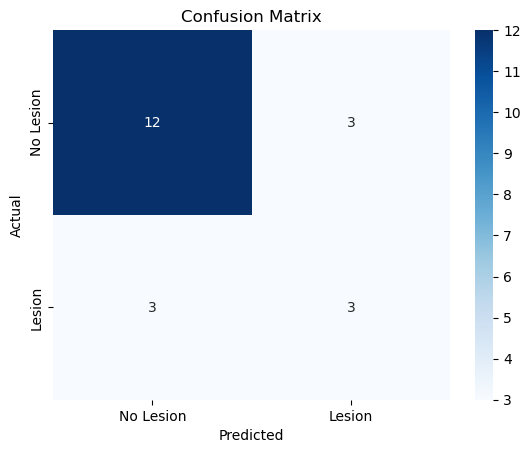

In [35]:

# === EVALUATE ===
print(" Evaluating best model...")
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = tta_sliding_window(model, images)
        lesion_detected = lesion_present(pred_mask)
        y_pred.append(lesion_detected)
        y_true.append(int(np.any(true_mask)))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print("\n Test Set Detection-Level Metrics:")
print(f" Accuracy:  {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall:    {rec:.4f}")
print(f" F1 Score:  {f1:.4f}")

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lesion", "Lesion"], yticklabels=["No Lesion", "Lesion"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Evaluates the trained Attention UNet using Dice score and detection accuracy, applying morphological cleaning and overlay visualisation.

 Evaluating the Model


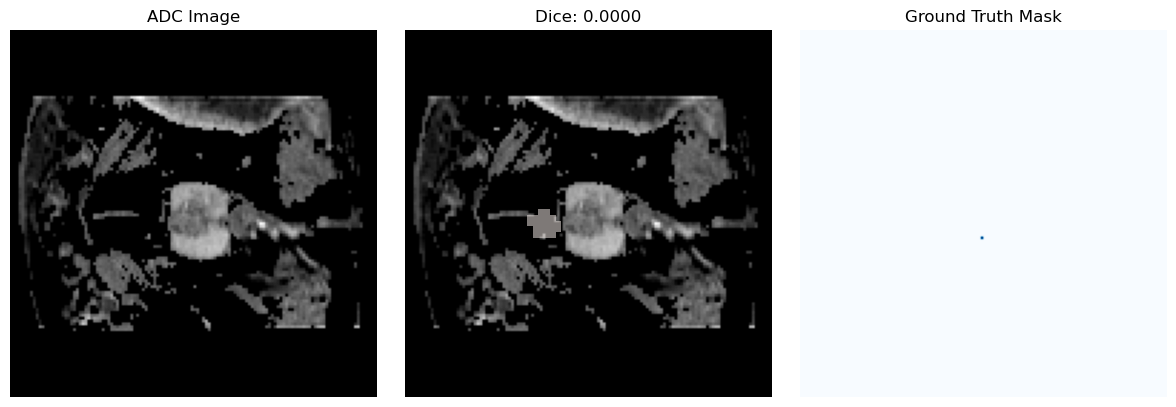

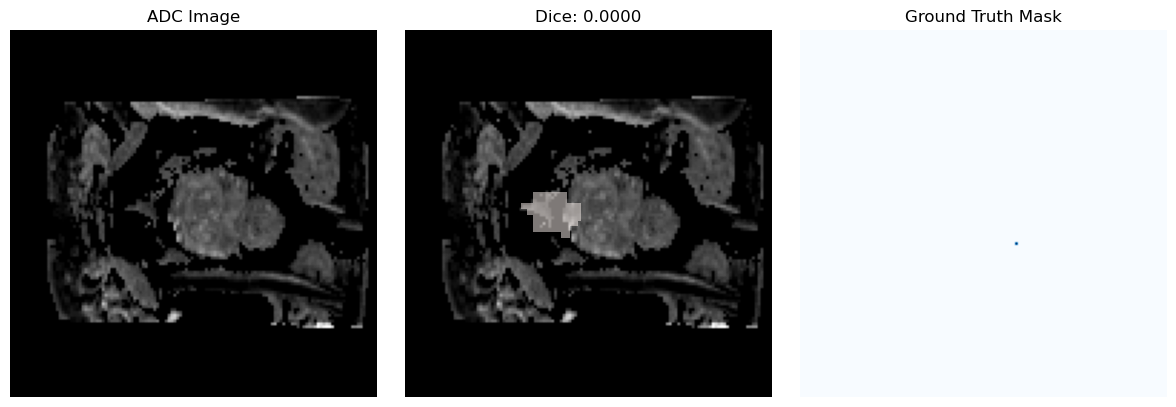

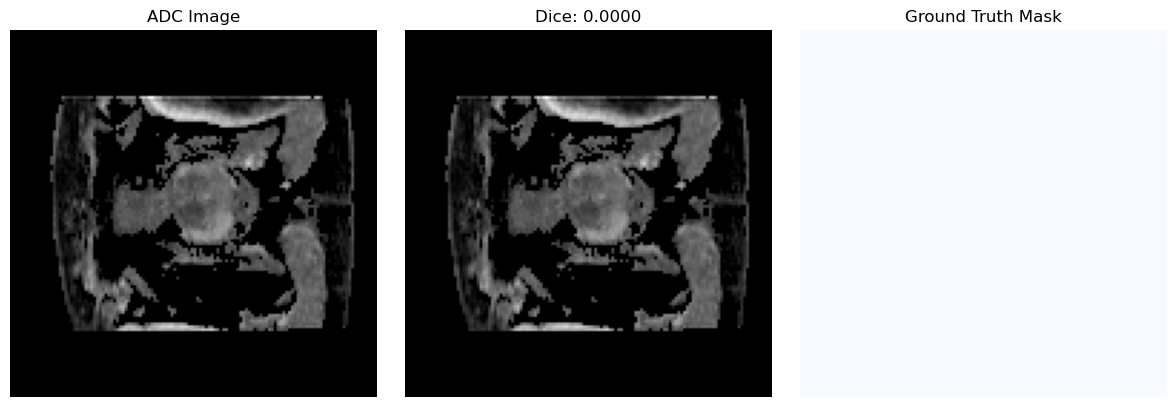

In [39]:
def generate_label_mask(image, ijk_list, radius=2):
    """
    Creates a binary 3D mask around lesion coordinates (ijk_list) by marking a small cubic region (radius-controlled) around each point.
    """
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                for dz in range(-radius, radius + 1):
                    xi, yj, zk = i + dx, j + dy, k + dz
                    if 0 <= zk < label.shape[0] and 0 <= yj < label.shape[1] and 0 <= xi < label.shape[2]:
                        label[zk, yj, xi] = 1
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result


def clean_prediction(pred_mask, structure_size=3):
    """
    Applies 3D morphological closing to each predicted mask to fill small holes and smooth boundaries. This helps reduce noise and improve segmentation coherence.
    """
    cleaned = []
    for m in pred_mask:
        m = binary_closing(m, structure=np.ones((structure_size, structure_size, structure_size)))
        cleaned.append(m.astype(np.uint8))
    return np.array(cleaned)


# === Evaluation with Dice Score + Visualisation ===
dice_metric = DiceMetric(include_background=False, reduction="mean")

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []
dice_scores = []

print(" Evaluating the Model")
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
        pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
        pred_mask = keep_largest_component(pred_mask)
        pred_mask = clean_prediction(pred_mask, structure_size=3)

        lesion_detected = int(np.any(pred_mask) and pred_mask.sum() > 500)
        y_pred.append(lesion_detected)
        y_true.append(int(np.any(true_mask)))

        # === Dice calculation (if lesion present in GT or prediction) ===
        if np.any(pred_mask) or np.any(true_mask):
            pred_tensor = torch.tensor(pred_mask).unsqueeze(1)
            true_tensor = torch.tensor(true_mask, dtype=torch.uint8).unsqueeze(1)
            dice = dice_metric(pred_tensor, true_tensor).item()
            dice_scores.append(dice)

        # === Visualise first 3 patients only ===
        if idx < 3:
            # Use ADC instead of T2 for overlay
            img = images[0][0].cpu().numpy()  # ADC image (resample reference)
            slice_idx = img.shape[2] // 2
        
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        
            # T2 image (unchanged)
            axs[0].imshow(img[:, :, slice_idx], cmap="gray")
            axs[0].set_title("ADC Image")
            axs[0].axis("off")
        
            # Overlay both prediction and ground truth
            pred_overlay = np.ma.masked_where(pred_mask[0][:, :, slice_idx] == 0, pred_mask[0][:, :, slice_idx])
            gt_overlay = np.ma.masked_where(true_mask[0].squeeze()[:, :, slice_idx] == 0, true_mask[0].squeeze()[:, :, slice_idx])
        
            axs[1].imshow(img[:, :, slice_idx], cmap="gray")
            axs[1].imshow(gt_overlay, cmap="Blues", alpha=0.5)
            axs[1].imshow(pred_overlay, cmap="Reds", alpha=0.5)
            axs[1].set_title(f"Dice: {dice:.4f}")
            axs[1].axis("off")
        
            # Ground Truth only for reference
            axs[2].imshow(true_mask[0].squeeze()[:, :, slice_idx], cmap="Blues")
            axs[2].set_title("Ground Truth Mask")
            axs[2].axis("off")
        
            plt.tight_layout()
            plt.show()



